In [1]:
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
import warnings
import os
import imageio

from src.features.utils import (
    get_data,
    process_str_data_to_json_requirements,
    read_as_dict,
    get_dataframe_from_dict,
)

In [2]:
warnings.filterwarnings('ignore')

In [3]:
path = '../data/raw/meteorological_information.csv'
data = pd.read_csv(path)

In [4]:
data.data_link.iloc[0]

'https://archive-api.open-meteo.com/v1/archive?latitude=21.81140007349488&longitude=-102.29587199103725&start_date=1980-01-01&end_date=2023-06-15&daily=weathercode,temperature_2m_max,temperature_2m_min,temperature_2m_mean,apparent_temperature_max,apparent_temperature_min,apparent_temperature_mean,sunrise,sunset,shortwave_radiation_sum,precipitation_sum,rain_sum,precipitation_hours&timezone=GMT'

In [5]:
gdl_data = data[data.NOMGEO.isin(['Guadalajara'])].meteorological_information
jal_data = data[data.CVE_ENT==14].meteorological_information

In [6]:
gdl_data_val = gdl_data.apply(process_str_data_to_json_requirements).apply(json.loads).values[0]
jal_data_val = jal_data.apply(process_str_data_to_json_requirements).apply(json.loads)
jal_data_daily = pd.concat(jal_data_val.apply(lambda x: pd.DataFrame(x['daily'])).to_list(), axis=0)
jal_data_daily_grouped = jal_data_daily.groupby('time')[jal_data_daily.describe().columns].mean().reset_index().iloc[:-2]

In [7]:
daily = jal_data_daily_grouped

In [8]:
#daily = pd.DataFrame(gdl_data_val['daily'])
daily.time = pd.to_datetime(daily.time)
daily['month'] = daily.time.dt.month
daily['year'] = daily.time.dt.year
daily['day'] = daily.time.dt.day_of_year
daily = daily.sort_values('time').iloc[:-2]
daily['radians'] = daily.day/(daily.day.max())*2*np.pi

In [9]:
daily.columns

Index(['time', 'weathercode', 'temperature_2m_max', 'temperature_2m_min',
       'temperature_2m_mean', 'apparent_temperature_max',
       'apparent_temperature_min', 'apparent_temperature_mean',
       'shortwave_radiation_sum', 'precipitation_sum', 'rain_sum',
       'precipitation_hours', 'month', 'year', 'day', 'radians'],
      dtype='object')

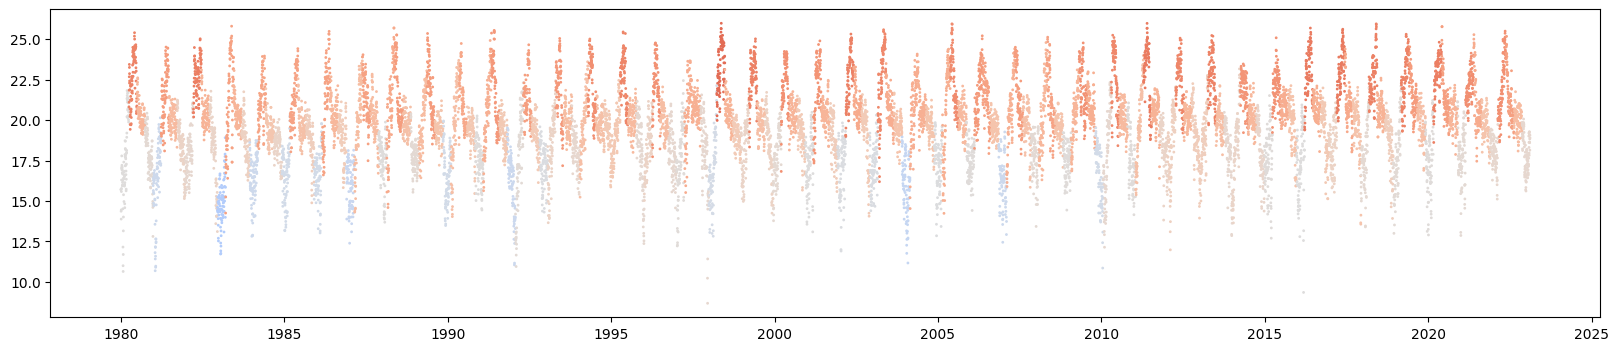

In [10]:
window = 90
feature = 'temperature_2m_mean'
plt.figure(figsize=(20, 4))
for step in range(len(daily)//window):
    temporal_daily = daily.iloc[window*(step-1):window*step]
    temporal_daily['color'] = temporal_daily[feature].mean()
    sc = plt.scatter(
        temporal_daily.time, 
        temporal_daily[feature], 
        c=temporal_daily.color,
        vmin=daily[feature].min(), 
        vmax=daily[feature].max(),
        cmap='coolwarm',
        s=1,
    )

In [25]:
def plot_feature_intime(feature):
    fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, facecolor='darkgray')
    months = ['ENE', 'FEB', 'MAR', 'ABR', 'MAY','JUN', 'JUL', 'AGO', 'SEP', 'OCT', 'NOV', 'DIC']
    lines, labels = plt.thetagrids(
        range(0, 360, int(360//len(months))),
        (months)
    )

    for step in range(1,len(daily)//window):
        temporal_daily = daily.iloc[window*(step-1):window*step]
        temporal_daily['color'] = temporal_daily[feature].mean()
        ax.scatter(
            temporal_daily.radians, 
            temporal_daily[feature], 
            c=temporal_daily.color,
            vmin=daily[feature].min(), 
            vmax=daily[feature].max(),
            cmap='coolwarm',
            s=10,
            edgecolors='k',
            linewidths=0.1
        )
        ax.set_rmin(0)
        #ax.set_rmax(30)
        ax.set_theta_offset(np.pi/2)
        ax.set_theta_direction(-1)
        ax.set_title('Temperatura promedio en jalisco')
        #ax.set_rticks([5, 10, 15, 20, 25,],['5°C','10°C','15°C','20°C','25°C',])
        ax.set_facecolor("darkgray")
        text = ax.text(
            0,
            0,
            str(temporal_daily.year.unique()[0]),
            horizontalalignment='center',
            verticalalignment='center', 
            fontsize=15,
            fontname='DejaVu Sans Display'
        )
        #plt.savefig(f'./meteorological_imgs/file_{str(step).zfill(4)}.png')
        text.remove()



    # images = []
    # filenames = os.listdir('meteorological_imgs')
    # for filename in filenames:
    #     images.append(imageio.imread(f'meteorological_imgs/{filename}'))
    # imageio.mimsave('./meteorological.gif', images)

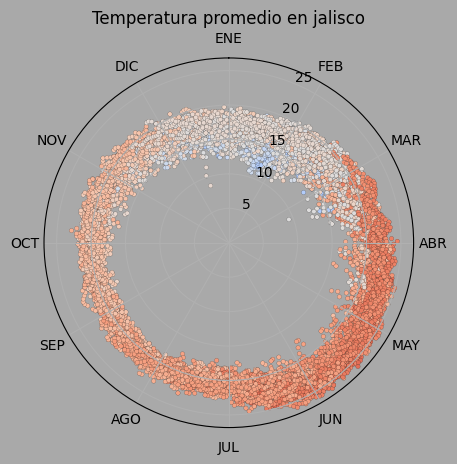

In [26]:
feature = 'temperature_2m_mean'
plot_feature_intime(feature)

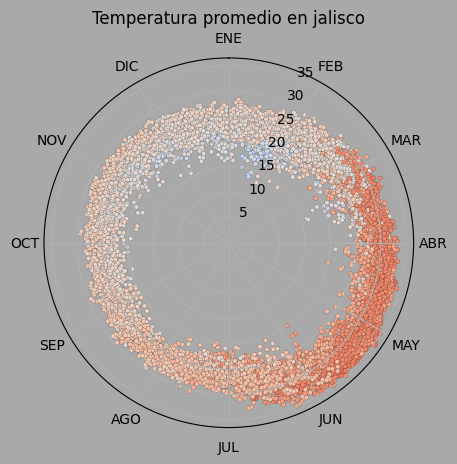

In [27]:
feature = 'temperature_2m_max'
plot_feature_intime(feature)

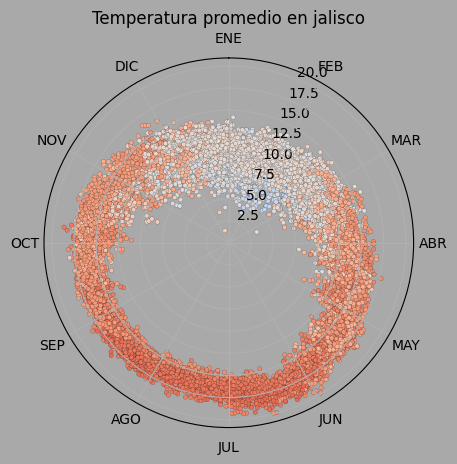

In [31]:
feature = 'temperature_2m_min'
plot_feature_intime(feature)

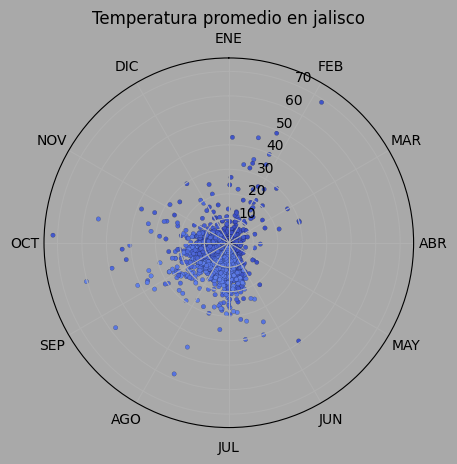

In [28]:
feature = 'rain_sum'
plot_feature_intime(feature)

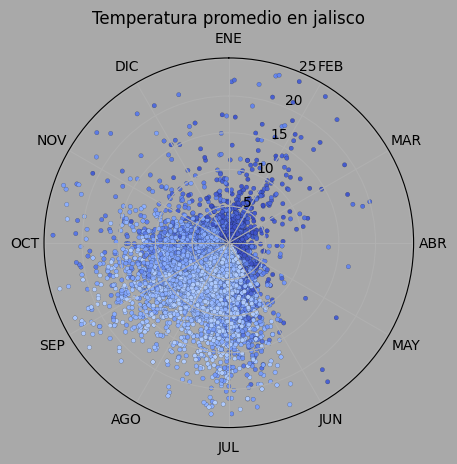

In [29]:
feature = 'precipitation_hours'
plot_feature_intime(feature)

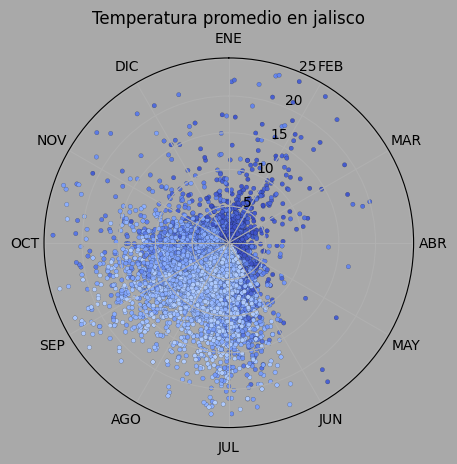

In [30]:
feature = 'precipitation_hours'
plot_feature_intime(feature)

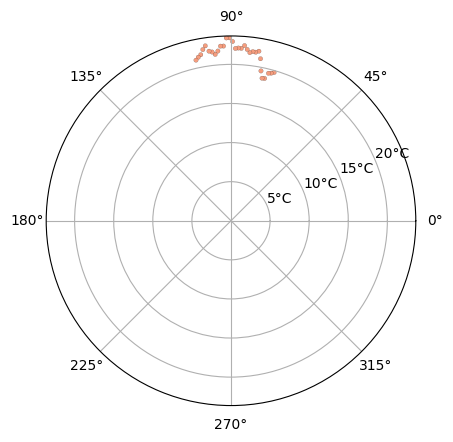

In [260]:
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})

ax.scatter(
        temporal_daily.radians, 
        temporal_daily[feature], 
        c=temporal_daily.color,
        vmin=daily[feature].min(), 
        vmax=daily[feature].max(),
        cmap='coolwarm',
        s=10,
        edgecolors='k',
        linewidths=0.1
    )